# Predicting Titanic Survival

## 1. Introduction to the Problem

Rules Reminder:

* You should submit a csv file with exactly 418 entries plus a header row. 
* Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.
* The file should have exactly 2 columns:
  * PassengerId (sorted in any order)
  * Survived (contains your binary predictions: 1 for survived, 0 for deceased)

## 2. Raw Data Collection

### 2.1 Basics of Data Collection

Since data is already available to us in a CSV we do not have to worry about data extraction techniques such as webscrapping or data governance and just need to import and clean our data

### 2.2 Importing Libraries

In [1]:
# Data Analysis/Wrangling
import numpy as np #for dealing with arrays
import pandas as pd #for dealing with dataframes
import xgboost as xgb
import re


# Visualization
import matplotlib.pyplot as plt #for visualization with matplotlib
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
%matplotlib inline
import seaborn as sns #for visualization with seaborn
from scipy import stats #for descriptive statistics such as pearson coef
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


print('libraries imported')

libraries imported


### 2.3 Importing and setting up our dataframes 

In [2]:
#import data sets from csv and put into a dataframe
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
IDtest = test_df["PassengerId"]

full_df = pd.concat([train_df,test_df])
full_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3. Data Pre-Processing 1

### 3.1 Order of Operations - What We Will Do:

1. Take a quick look at the pandas profile
2. Look at distribution of the data (both numerical and categorical)
3. Initial analysis through visualization
4. Data Wrangling: 
  * Correct - Review the data for any missing data, duplicate data or outliers and determine if necessary to deal with
  * Complete - Fix missing values by filling them in 
  * Create -  by extracting new features from existing
  * Converte - change data type to help with modeling

### 3.2 Pandas_profiling & Finding Unique Values in Each Column

In [ ]:
import pandas_profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(train_df, title="Basics of the Data")
profile.to_widgets()

In [ ]:
print(train_df.apply(lambda col: col.nunique()))

### 3.3 Look at the distribution of the data

#### Lets take a look at the distribution of numerical data:

In [ ]:
train_df.describe()

#### Now look at distribution of categorical data:

In [ ]:
train_df.describe(include=['O'])

#### What does the distribution tell us?

* Mostly men (577/891)
* Ages ranged from 0.42 to 80 years of age
* Every passanger has a unique ID
* They embarked from 3 unique locations - mainly S (644/889)
* There are 3 seperate P classes, mainly class 3

#### *Next Steps - Look at Assumptions or Questions About the Data:

* Correlating - we know there will be correlations, but where are the correlations in the dataset?
* Completing - How can we correct the missing data?
* Correcting - What data can we remove from the set for being not useful?
* Creating - Can we group any of these categories in a way that is useful?
* Classifying - Can we make any determinations based on classifiers such as sex and Pclass?

### 3.4 Initial Data Analysis

#### Analyzing by individual features

In [ ]:
train_df[["Sex","Survived"]].groupby('Sex').mean()

Women were most likely to survive

In [ ]:
train_df[["Age","Survived"]].groupby('Survived').mean()

Looks like younger people were more likely to survive

In [ ]:
train_df[["Pclass","Survived"]].groupby('Pclass').mean()

In [ ]:
train_df[["Pclass","Sex","Survived"]].groupby('Sex').median()

Mostly men from third class who did not survive and first class in general was most likely to survive

In [ ]:
train_df[["SibSp","Survived"]].groupby('SibSp').mean()

Small families were the most likely to survive

In [ ]:
train_df[["Pclass","Age","Survived"]].groupby('Pclass').median()

In [ ]:
train_df[["Embarked","Survived"]].groupby('Embarked').mean()

In [ ]:
train_df[["Embarked","Survived","Pclass"]].groupby('Embarked').median()

Mostly people who embarked from C survived and Most of the first class passengers embarked from C...interesting! 

#### Analyzing by visualization

In [ ]:
import phik
import seaborn as sns

# Pearson's correlation matrix between numeric variables (pandas functionality)
train_df.corr()

# get the phi_k correlation matrix between all variables
df1 = train_df.phik_matrix()
ax = sns.heatmap(df1)

In [ ]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train_df, hue='Sex', palette='rocket')
ax.set_ylim(0,500)
plt.title("Survival Based on Sex")
plt.show()

In [ ]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train_df, hue='Embarked', palette='rocket')
ax.set_ylim(0,500)
plt.title("Survival based on Embarkment Location")
plt.show()


In [ ]:
fig, ax=plt.subplots(figsize=(8,6))
sns.countplot(x='Survived', data=train_df, hue='Pclass', palette='rocket')
ax.set_ylim(0,400)
plt.title("Survival base on Pclass")
plt.show()

In [ ]:
# Explore SibSp feature vs Survived
df = sns.factorplot(x="SibSp",y="Survived",data=train_df,kind="bar", size = 6 , 
palette = 'rocket')
df.despine(left=True)
df = df.set_ylabels("survival probability")

In [ ]:
# Explore Parch feature vs Survived
df  = sns.factorplot(x="Parch",y="Survived",data=train_df,kind="bar", size = 6 , 
palette = 'rocket')
df.despine(left=True)
df = df.set_ylabels("survival probability")

In [ ]:
df = sns.factorplot(x="Survived", y = "Age",data = train_df, kind="box", palette = 'rocket')
df = sns.factorplot(x="Survived", y = "Age",data = train_df, kind="violin", palette = 'rocket')

### 3.5 Data Wrangling

#### Correcting: checking for unneccessary or incorrect data

What kind of data are we missing?  This will need to be dropped or corrected later

In [3]:
full_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Since we have so many missing cabin numbers and ticket numbers and PassengerID will not provide much insight for predictions with modeling I am going to drop those three columns

In [4]:
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['Cabin', 'Ticket']
train_df.drop(drop_column, axis=1, inplace = True)
drop_column = ['Cabin', 'Ticket']
test_df.drop(drop_column, axis=1, inplace = True)

Any duplicates?

In [ ]:
duplicate = train_df[train_df.duplicated()]
duplicate

What are our outliers?

In [5]:
Q1 = train_df.quantile(0.25)
Q3 = train_df.quantile(0.75)
IQR = Q3 - Q1

#find upper and lower limits
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

#find amount of outliers in charges
cols = ['Fare','SibSp','Parch','Pclass']
((train_df[cols] < (Q1 - 1.5 * IQR)) |(train_df[cols] > (Q3 + 1.5 * IQR))).sum()

Age              0
Fare           116
Parch          213
PassengerId      0
Pclass           0
SibSp           46
Survived         0
dtype: int64

Drop the outliers:

In [6]:
train_df = train_df[~((train_df[cols] < (Q1 - 1.5 * IQR)) |(train_df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
train_df.shape

(607, 10)

#### Completing: find and fill in missing values

In [7]:
data_cleaner = [train_df, test_df]


###COMPLETING: complete or delete missing values in train and test/validation dataset
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    

print(train_df.isnull().sum())
print("-"*10)
print(test_df.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
----------
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


#### Creating: Feature Engineering - change this to test data set? 

Lets create a column called "family size" to include both the SibSp and the Parch since that will include all the parents and children

In [8]:
# Feature engineering steps from Sina
data_cleaner = [train_df, test_df]

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
# Create new feature IsAlone from FamilySize
for dataset in data_cleaner:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

#### Converting: Changing Datatypes

What We Know About the Data Breakdown:

* Categorical:
  * Survived
  * Sex
  * Embarked
* Ordinal: 
  * Pclass
* Numerical:
  * Age
  * Fare
* Discrete:
  * SibSp
  * Parch 

In [ ]:
test_df.dtypes

In [ ]:
train_df.dtypes

In [9]:
train_len = len(train_df)
dataset =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)

In [10]:
dataset["Title"] = dataset["Name"].str.extract(" ([A-Za-z]+)\.")
dataset["Title"] = dataset["Title"].replace(["Ms", "Mlle"], "Miss")
dataset["Title"] = dataset["Title"].replace(["Mme", "Countess", "Lady", "Dona"], "Mrs")
dataset["Title"] = dataset["Title"].replace(["Dr", "Major", "Col", "Sir", "Rev", "Jonkheer", "Capt", "Don"], "Mr")
dataset = dataset.drop(["Name"], axis=1)

In [12]:
one_hot_cols = ["Embarked","Title","Sex","Pclass"]
for col in one_hot_cols:
    dataset = pd.concat(
        [dataset, pd.get_dummies(dataset[col], prefix=col)], 
        axis=1, 
        join="inner",
    )
dataset = dataset.drop(one_hot_cols, axis=1)

In [13]:
dataset.drop(labels = ["PassengerId", ""], axis = 1, inplace = True)

In [16]:
dataset.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,0.0,22.0,1,0,7.2500,2,0,0,0,1,0,0,1,0,0,1,0,0,1
1,1.0,26.0,0,0,7.9250,1,1,0,0,1,0,1,0,0,1,0,0,0,1
2,1.0,35.0,1,0,53.1000,2,0,0,0,1,0,0,0,1,1,0,1,0,0
3,0.0,35.0,0,0,8.0500,1,1,0,0,1,0,0,1,0,0,1,0,0,1
4,0.0,29.0,0,0,8.4583,1,1,0,1,0,0,0,1,0,0,1,0,0,1


## 4. Data Pre-Processing 2

### 4.1 Basics of Data Pre-Processing 2:
* Split into test and train set
* Statistical Data Analysis
* Feature Selection
* Feature Scaling
* Dimensional Reduction Where Necessary

In [17]:
#Split into test and train

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)



In [19]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

X_train.head()

,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,7.2500,2,0,0,0,1,0,0,1,0,0,1,0,0,1
1,26.0,0,0,7.9250,1,1,0,0,1,0,1,0,0,1,0,0,0,1
2,35.0,1,0,53.1000,2,0,0,0,1,0,0,0,1,1,0,1,0,0
3,35.0,0,0,8.0500,1,1,0,0,1,0,0,1,0,0,1,0,0,1
4,29.0,0,0,8.4583,1,1,0,1,0,0,0,1,0,0,1,0,0,1


## 5. Model Selection and Evaluation

### 5.1 Model Selections

* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer percepton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [20]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [21]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

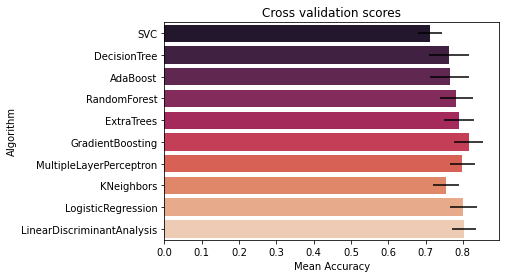

In [22]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighbors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="rocket",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

### 5.2 Hypertuning the Parameters

Meta Modeling with Adaboost,ExtraTrees, Random Forest, and Gradientboosting

In [23]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    6.6s finished


0.7873497267759563

In [24]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.4min finished


0.8237158469945355

In [25]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.6min finished


0.8171584699453552

In [26]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   38.1s finished


0.8169672131147541

In [27]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   22.0s finished


0.8155191256830602

### 5.3 Refine Model and Score Performance

Plotting to see the curves after modeling

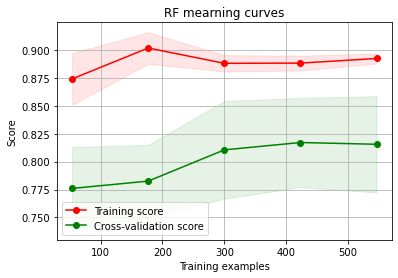

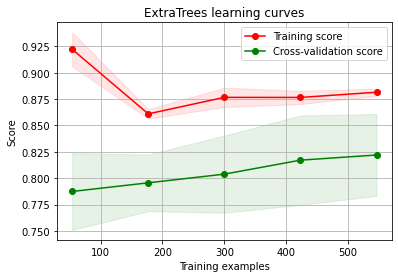

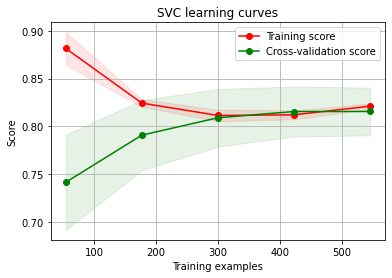

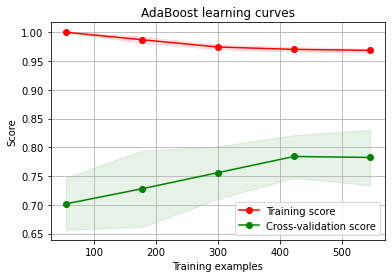

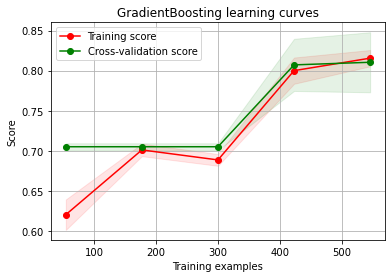

In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

Now we will refine with feature importance

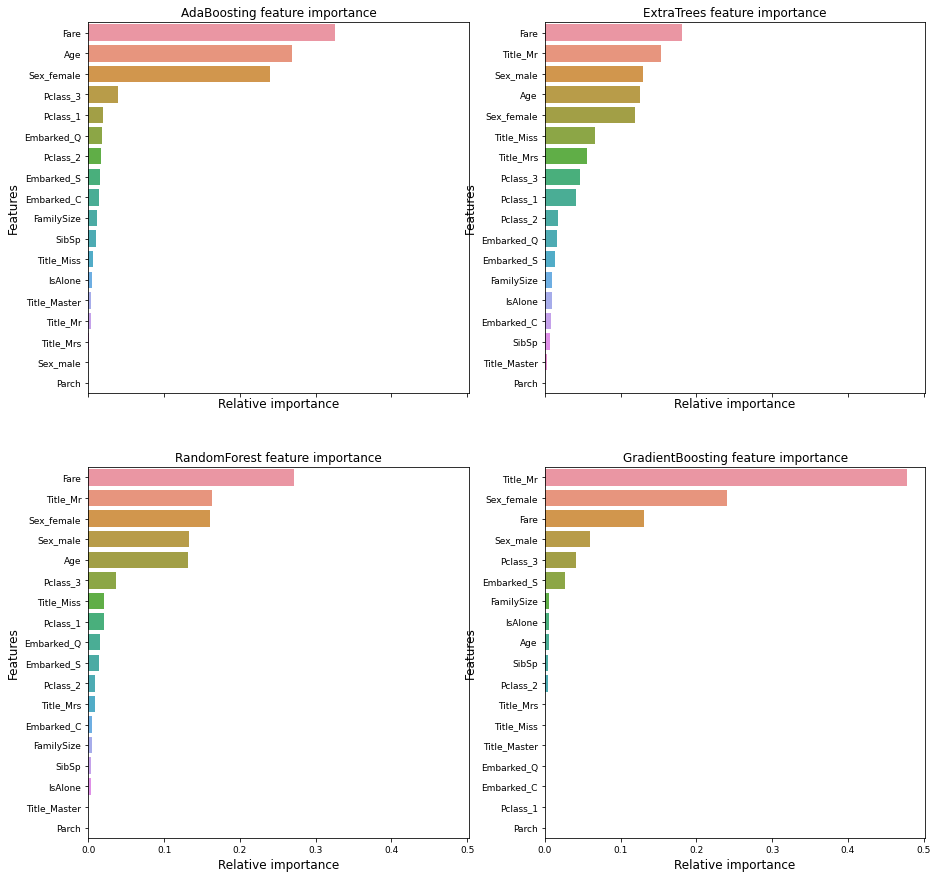

In [29]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

## 6. Predictions and Conclusion

### 6.1 Build Final Model and Run Predictions

In [57]:
votingC = VotingClassifier(estimators=[('DTC', ada_best),('extc', ExtC_best),
('svc', SVMC_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.2 Save file for sharing

In [58]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("7_submission_titanic.csv",index=False)

ValueError: Number of features of the model must match the input. Model n_features is 11 and input n_features is 18 

### 6.3 Final Thoughts